<a href="https://colab.research.google.com/github/dLobatog/kaggle-competitions/blob/main/Sartorius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/Colab\ Notebooks/kaggle
    from setup_colab import setup_colab_for_kaggle
    setup_colab_for_kaggle(check_env=False, local_working=True)
except:
    print("Not in Colab")

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Content of Drive Kaggle data dir (/content/drive/MyDrive/kaggle): ['/content/drive/MyDrive/kaggle/input', '/content/drive/MyDrive/kaggle/output']
Content of Kaggle data dir (/kaggle): ['/kaggle/output', '/kaggle/input', '/kaggle/working']
Content of Kaggle data subdir (/kaggle/input): []
Content of Kaggle data subdir (/kaggle/output): []
Content of Kaggle data subdir (/kaggle/working): []
Content of Kaggle config dir (/root/.kaggle): ['/root/.kaggle/kaggle.json']


In [2]:
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json 

In [3]:
#!mkdir sartorius
%cd sartorius
#!mkdir train
#!mkdir test
TRAIN_CSV = "train.csv"
TRAIN_PATH = "train"
TEST_PATH = "test"

/content/drive/My Drive/Colab Notebooks/kaggle/sartorius


In [4]:
#!pip uninstall -y kaggle
#!pip install --upgrade pip
#!pip install kaggle

In [5]:
#!kaggle competitions download -c sartorius-cell-instance-segmentation 

In [6]:
#!unzip sartorius-cell-instance-segmentation.zip

In [7]:
import pandas as pd
import cv2
import numpy as np
from torchvision.io import read_image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io
from pathlib import Path
from PIL import Image

In [8]:
train = pd.read_csv('train.csv')

In [9]:
train['annotation'][0]

'118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4'

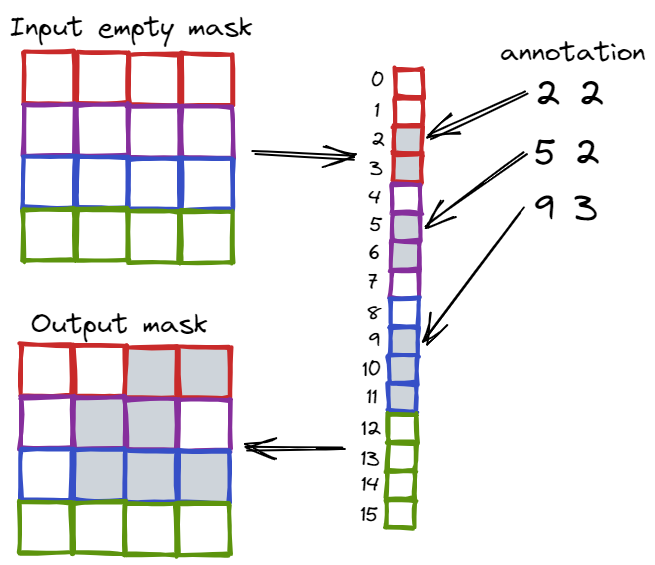

In [10]:
def decodeRLE(annotation, imgShape=(520,704)):
    s = annotation.split(' ')
    pixelList = []
    for i in range(len(s)//2):
        start = int(s[2*i])
        increment = int(s[2*i+1])
        for j in range(start,start+increment):
            pixelList.append(j)
    annotation = np.zeros(imgShape).flatten()
    annotation[pixelList] = 1.
    annotation = annotation.reshape(imgShape)
    return annotation

decodeRLE(train['annotation'][0])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

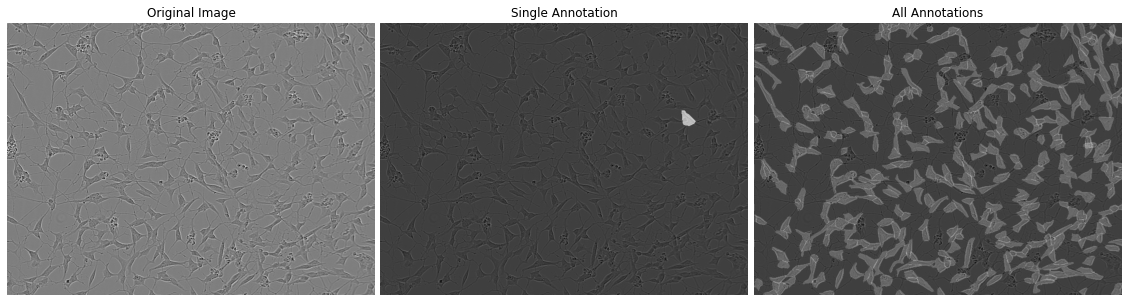

In [11]:
imageID = '0030fd0e6378'

fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.01)

# Load the image
img = read_image('train/' + imageID + '.png').squeeze()
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Single Annotation
singleAnnotation = decodeRLE(train.iloc[0,1])
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.imshow(singleAnnotation, cmap='gray', alpha=0.5)
plt.title('Single Annotation')
plt.axis('off')

# All annotations
allAnnotations = np.zeros(img.shape)
train_subset = train[train['id']==imageID]
for index, row in train_subset.iterrows():
    allAnnotations += decodeRLE(row.annotation)
plt.subplot(133)
plt.imshow(img, cmap='gray')
plt.imshow(allAnnotations, cmap='gray', alpha=0.5)
plt.title('All Annotations')
plt.axis('off')

plt.show()

In [12]:
train[train['id']==imageID]

id  ... elapsed_timedelta
0    0030fd0e6378  ...   0 days 11:30:00
1    0030fd0e6378  ...   0 days 11:30:00
2    0030fd0e6378  ...   0 days 11:30:00
3    0030fd0e6378  ...   0 days 11:30:00
4    0030fd0e6378  ...   0 days 11:30:00
..            ...  ...               ...
390  0030fd0e6378  ...   0 days 11:30:00
391  0030fd0e6378  ...   0 days 11:30:00
392  0030fd0e6378  ...   0 days 11:30:00
393  0030fd0e6378  ...   0 days 11:30:00
394  0030fd0e6378  ...   0 days 11:30:00

[395 rows x 9 columns]

### Load dataset in COCO 

COCO is a format for image detection that will allow us to send this code to detectron2

https://cocodataset.org/#overview

In [13]:
#!kaggle datasets download slawekbiel/sartorius-cell-instance-segmentation-coco --unzip --force

In [14]:
data_dir = Path('')
annotations_all = Path('annotations_all.json') 

In [15]:
coco = COCO(annotations_all)
image_ids = coco.getImgIds()
images = coco.loadImgs(image_ids[-3:])

loading annotations into memory...
Done (t=2.64s)
creating index...
index created!


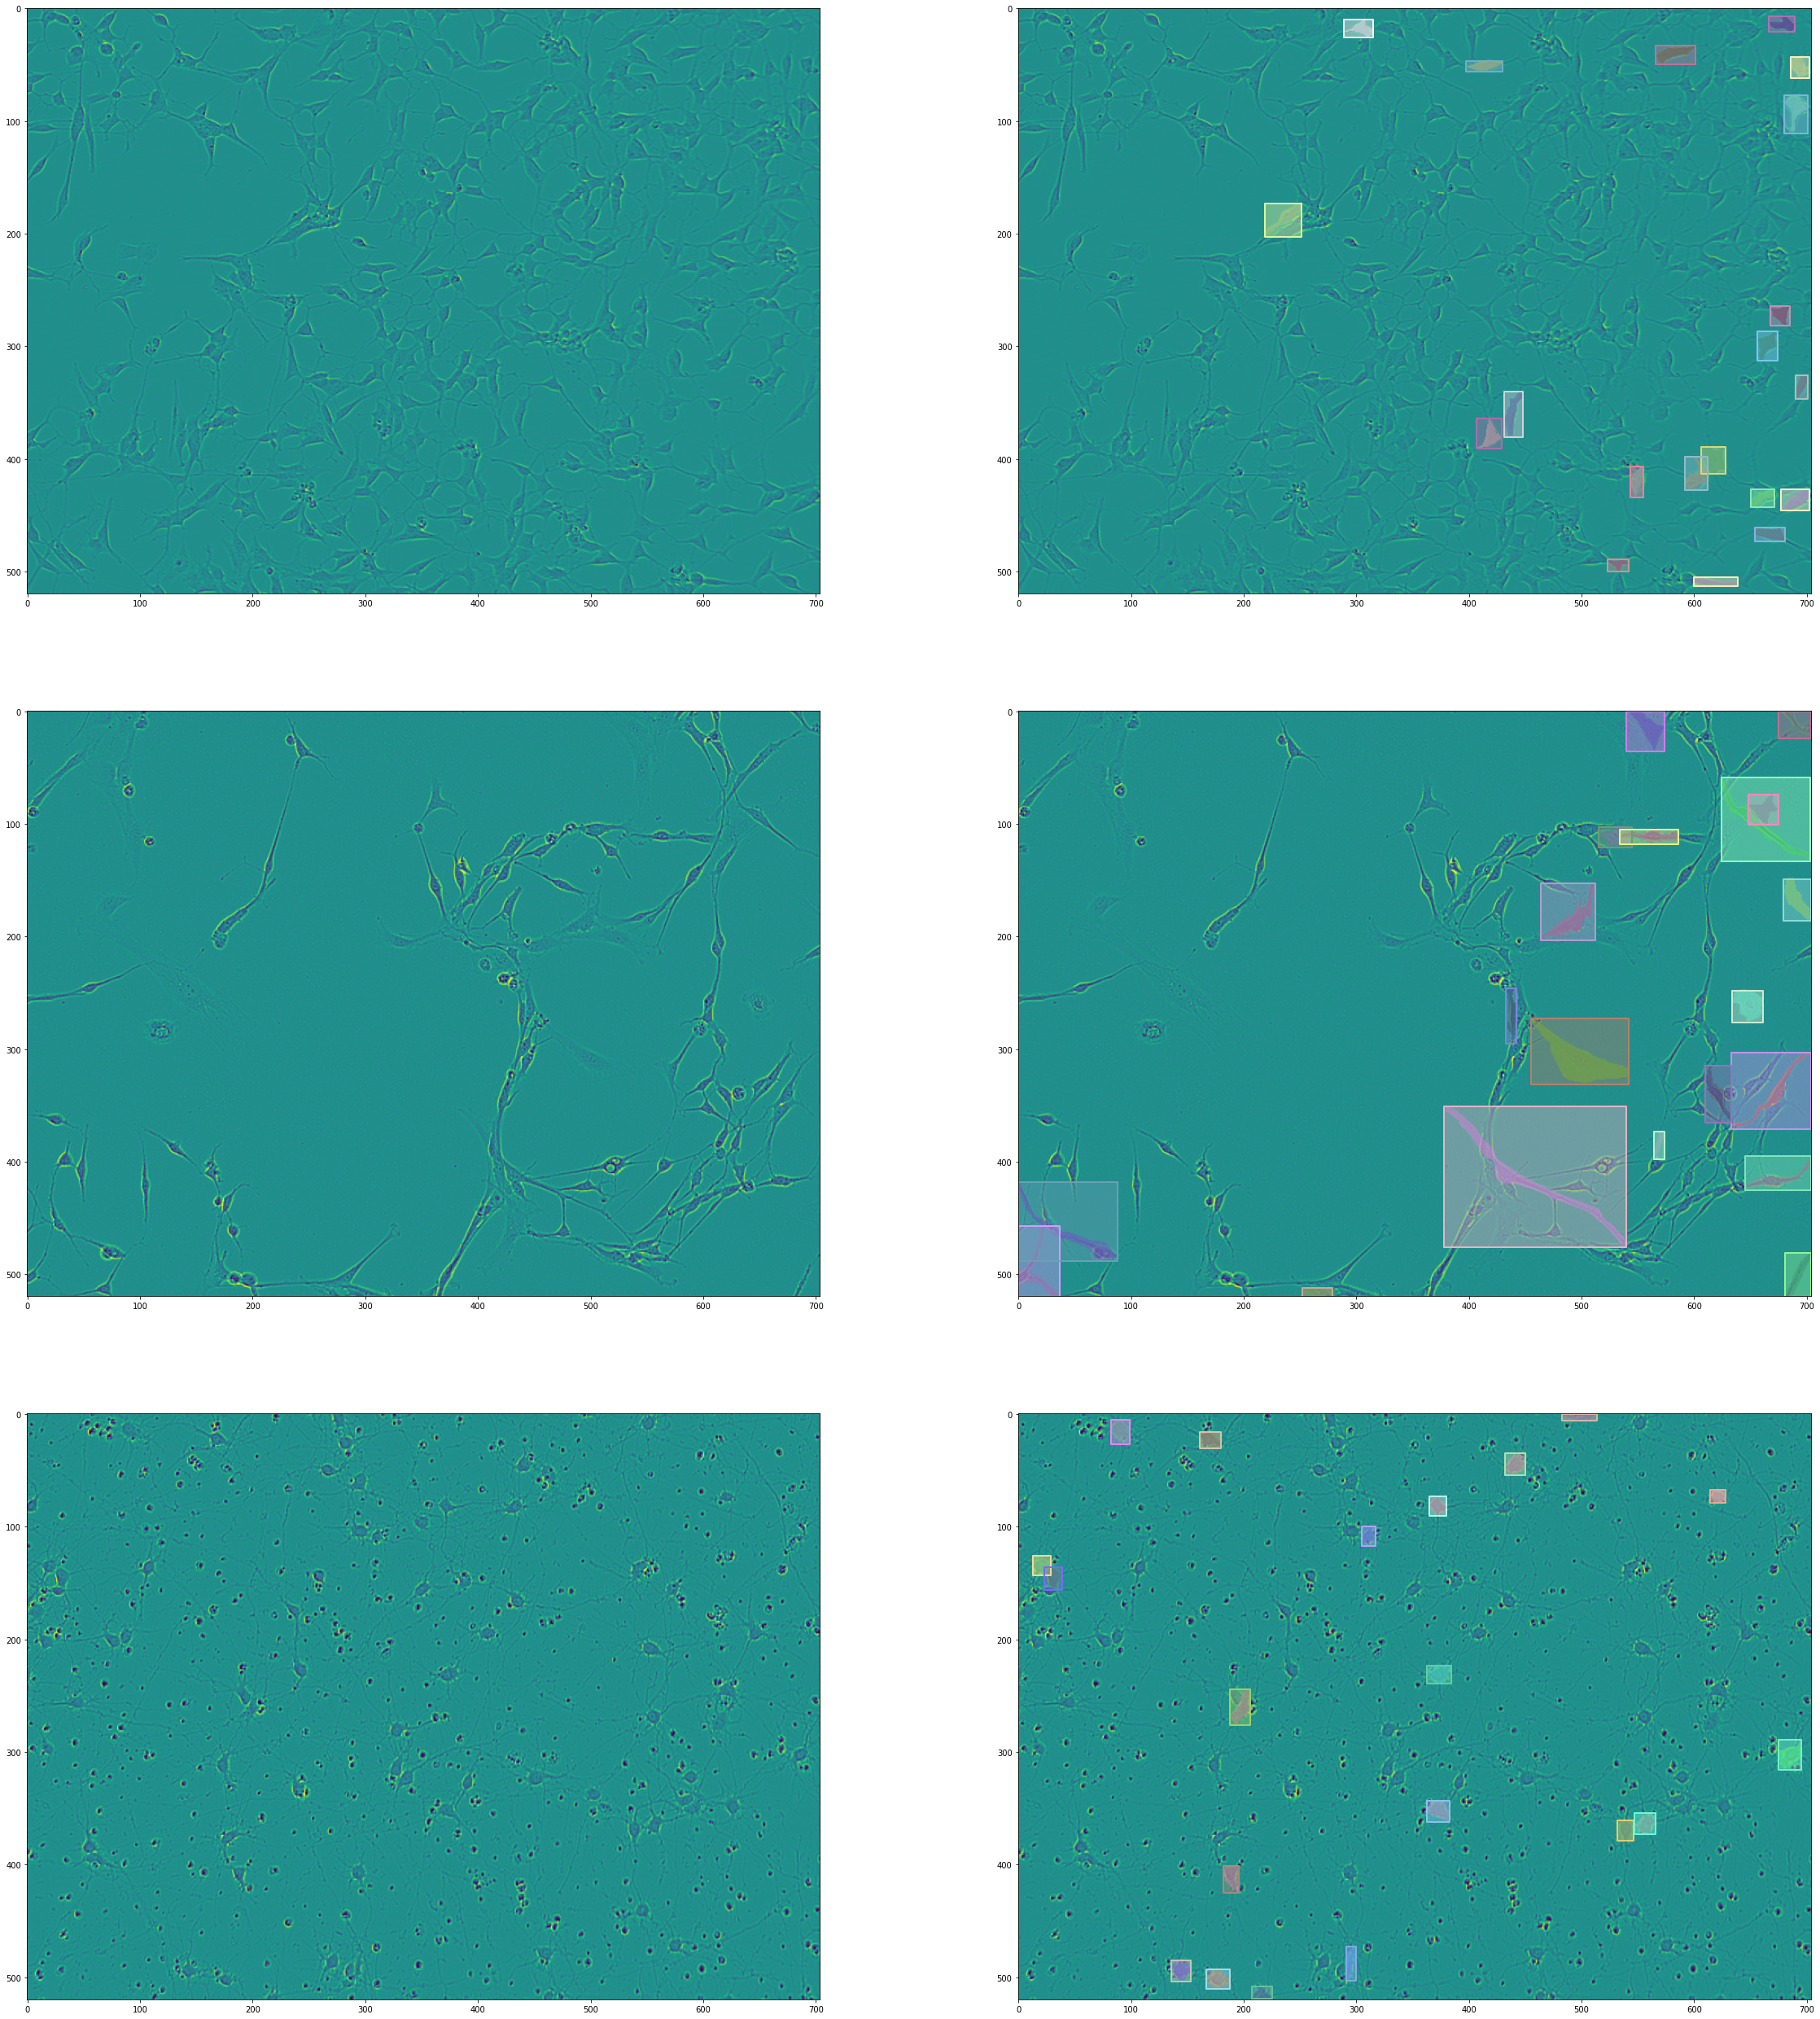

In [45]:
# Limited to 20 annotations per picture as otherwise it's too slow 

imgs = coco.loadImgs(image_ids[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(data_dir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])[-20:]
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)



In [26]:
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 6.6 MB/s 
     |████████████████████████████████| 74 kB 2.8 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 130 kB 18.9 MB/s 
     |████████████████████████████████| 145 kB 64.6 MB/s 
     |████████████████████████████████| 843 kB 57.8 MB/s 
     |████████████████████████████████| 749 kB 71.5 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
     |████████████████████████████████| 112 kB 85.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=7e6531f6a93646df33b03a8ddb7e4ed28ff795ba1e4a922974ce590a3e2fceb7
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=278

In [65]:
import detectron2
import multiprocessing
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator

In [47]:
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, 'annotations_train.json', data_dir)
register_coco_instances('sartorius_val',{},'annotations_val.json', data_dir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

In [90]:
metadata

Metadata(evaluator_type='coco', image_root=PosixPath('.'), json_file='annotations_train.json', name='sartorius_train', thing_classes=['shsy5y', 'astro', 'cort'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

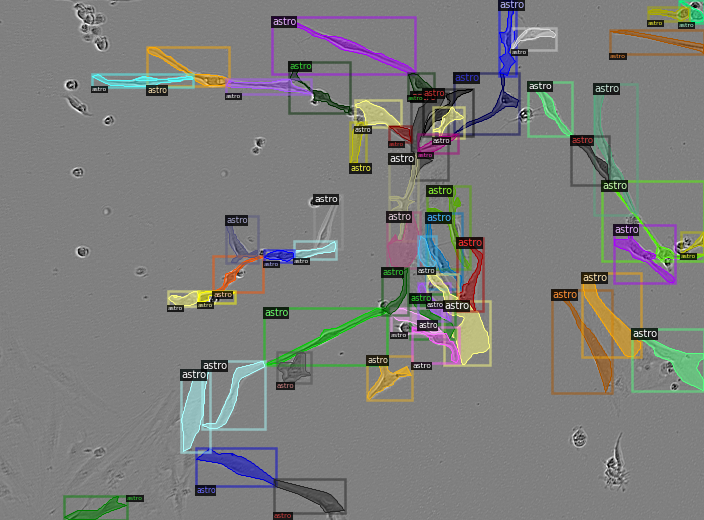

In [61]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
im = Image.fromarray(out.get_image())
display(im)

### Training step

Setup the config in Detectron2, start training

In [88]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('sartorius_train',)
cfg.DATASETS.TEST = ('sartorius_val',)
cfg.DATALOADER.NUM_WORKERS = multiprocessing.cpu_count()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 100 # just for testing
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # 3 types, neurons, astrocytes, neuroglioblastoma
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
# This loads the COCO model trained 3x schedule = ~37 COCO epochs. 
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH

[11/22 10:56:13 d2.data.datasets.coco]: Loading annotations_train.json takes 1.25 seconds.
[11/22 10:56:13 d2.data.datasets.coco]: Loaded 485 images in COCO format from annotations_train.json


After setting up the config for detectron, we need to create the loss metric: mean Average Precision (mAP) at different intersection over union (IoU) 

IoU(A,B)= A∩B/A∪B.

This metric sweeps over a range of IoU thresholds.
At each threshold value, we need to compute TP/TP+FP+FN (precision). 

In [74]:
def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)


class MAPIOUEvaluator(DatasetEvaluator):
  def __init__(self, dataset_name):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    self.annotations_cache = { item['image_id']:item['annotations'] for item in dataset_dicts }

  def reset(self):
    self.scores = []

  def process(self, inputs, outputs):
    for inp, out, in zip(inputs, outputs):
      if len(out['instances']) == 0:
        self.scores.append(0)
      else:
        targ = self.annotations_cache[inp['image_id']]
        self.scores.append(score(out, targ))

  def evaluate(self):
    return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

In [87]:
import os
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/22 10:51:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[11/22 10:51:59 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This ty

[11/22 10:52:12 d2.utils.events]:  eta: 1 day, 2:37:48  iter: 19  total_loss: 7.052  loss_cls: 1.312  loss_box_reg: 0.4536  loss_mask: 0.6937  loss_rpn_cls: 4.235  loss_rpn_loc: 0.3504  time: 0.5347  data_time: 0.3223  lr: 4.9952e-06  max_mem: 5879M
[11/22 10:52:26 d2.utils.events]:  eta: 1 day, 2:02:28  iter: 39  total_loss: 3.776  loss_cls: 1.249  loss_box_reg: 0.4058  loss_mask: 0.6916  loss_rpn_cls: 1.094  loss_rpn_loc: 0.3106  time: 0.6321  data_time: 0.3964  lr: 9.9902e-06  max_mem: 5879M
[11/22 10:52:45 d2.utils.events]:  eta: 1 day, 2:26:28  iter: 59  total_loss: 2.98  loss_cls: 1.141  loss_box_reg: 0.374  loss_mask: 0.69  loss_rpn_cls: 0.4734  loss_rpn_loc: 0.327  time: 0.7404  data_time: 0.5933  lr: 1.4985e-05  max_mem: 5879M
[11/22 10:52:58 d2.utils.events]:  eta: 1 day, 2:40:23  iter: 79  total_loss: 2.784  loss_cls: 0.9842  loss_box_reg: 0.4208  loss_mask: 0.6847  loss_rpn_cls: 0.3608  loss_rpn_loc: 0.3153  time: 0.7113  data_time: 0.2876  lr: 1.998e-05  max_mem: 5879M
[11

KeyboardInterrupt: ignored

In [ ]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res